#**Load Dataset**

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to ZIP file
zip_path = '/content/drive/MyDrive/pepper_bell.zip'

#Extract File
! unzip '/content/drive/MyDrive/pepper_bell.zip'

#**Classes**

In [3]:
import os

pepperbell_data = '/content/pepper_bell'
pepperbell_classes = os.listdir(pepperbell_data)

In [4]:
print("Pepper Bell Clases: ")
for classes in pepperbell_classes:
  if os.path.isdir(os.path.join(pepperbell_data, classes)):
    print(classes)

Pepper Bell Clases: 
Not__Pepper__bell
Pepper__bell___Bacterial_spot
Pepper__bell___healthy


#**Preprocessing Data**

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
import shutil
from PIL import Image

# Resize Dataset and Save to New Directory
resized_dir = "/content/drive/MyDrive/resized"
os.makedirs(resized_dir, exist_ok=True)

for item in pepperbell_classes:
  class_dir = os.path.join(pepperbell_data, item)
  class_images = os.listdir(class_dir)

  for img_path in class_images:
    img = Image.open(os.path.join(class_dir, img_path))
    resized_img = img.resize((256, 256))
    save_path = os.path.join(resized_dir, item, img_path) 
    os.makedirs(os.path.dirname(save_path), exist_ok=True)  
    resized_img.save(save_path)

In [7]:
# Content of Resize Dataset
!ls '/content/drive/MyDrive/resized'

Not__Pepper__bell  Pepper__bell___Bacterial_spot  Pepper__bell___healthy


#**Preview Dataset**


Not__Pepper__bell
Total Images: 802
Resolution of First Image: (256, 256, 3)


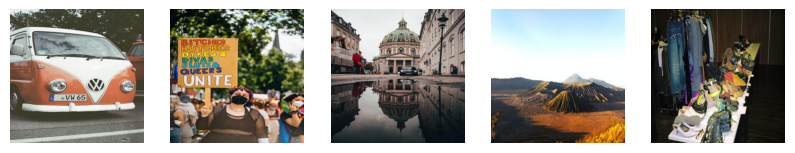


Pepper__bell___Bacterial_spot
Total Images: 997
Resolution of First Image: (256, 256, 3)


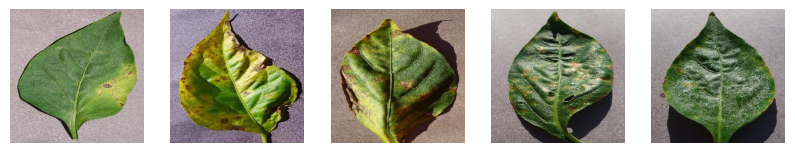


Pepper__bell___healthy
Total Images: 1478
Resolution of First Image: (256, 256, 3)


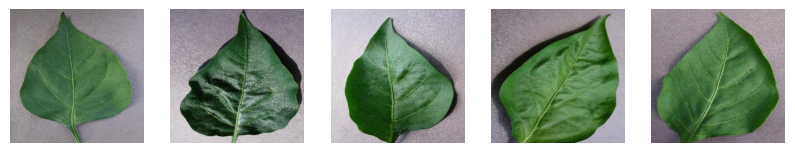

In [8]:
for item in pepperbell_classes:
  print("")
  print(item)
  class_dir = os.path.join(resized_dir, item)
  class_images = os.listdir(class_dir)

  # Total images in each classes
  num_images = len(class_images)
  print("Total Images:", num_images)

  # Resolution/size of each first image in class
  img_path = os.path.join(class_dir, class_images[0])
  img = mpimg.imread(img_path)
  image_shape = img.shape
  print("Resolution of First Image:", image_shape)

  # Showing some images
  plt.figure(figsize=(10, 5))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

#**Split Data**


In [9]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Train and Validation Directory
train_dir = '/content/drive/MyDrive/train'
validation_dir = '/content/drive/MyDrive/validation'

# Split Data into Training and Validation
class_directories = os.listdir(resized_dir)
for class_directory in class_directories:
    class_path = os.path.join(resized_dir, class_directory)
    if os.path.isdir(class_path):
        train_class_dir = os.path.join(train_dir, class_directory)
        os.makedirs(train_class_dir, exist_ok=True)
        val_class_dir = os.path.join(validation_dir, class_directory)
        os.makedirs(val_class_dir, exist_ok=True)
        
        class_images = os.listdir(class_path)
        train_images, val_images = train_test_split(class_images, test_size=0.2, random_state=42)
        
        for image in train_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(train_class_dir, image)
            shutil.copy(src, dst)
            
        for image in val_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(val_class_dir, image)
            shutil.copy(src, dst)

#**Training and Validation Generator**

In [10]:
# Create training and validation data generator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,
    vertical_flip=True  
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),  
    batch_size=20,
    class_mode='categorical'  
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical'
)


Found 2620 images belonging to 3 classes.
Found 657 images belonging to 3 classes.


#**Building Models**

In [11]:
import tensorflow as tf

# Model Definition
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [12]:
# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history= model.fit(
    train_generator, 
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/10
131/131 [==============================] - 78s 548ms/step - loss: 0.5691 - accuracy: 0.7427 - val_loss: 0.2364 - val_accuracy: 0.9011
Epoch 2/10
131/131 [==============================] - 72s 548ms/step - loss: 0.2899 - accuracy: 0.8996 - val_loss: 0.2548 - val_accuracy: 0.8843
Epoch 3/10
131/131 [==============================] - 63s 482ms/step - loss: 0.2566 - accuracy: 0.9153 - val_loss: 0.1817 - val_accuracy: 0.9361
Epoch 4/10
131/131 [==============================] - 62s 474ms/step - loss: 0.2045 - accuracy: 0.9385 - val_loss: 0.1282 - val_accuracy: 0.9543
Epoch 5/10
131/131 [==============================] - 63s 482ms/step - loss: 0.1916 - accuracy: 0.9382 - val_loss: 0.1030 - val_accuracy: 0.9680
Epoch 6/10
131/131 [==============================] - 62s 474ms/step - loss: 0.2168 - accuracy: 0.9313 - val_loss: 0.1560 - val_accuracy: 0.9559
Epoch 7/10
131/131 [==============================] - 72s 549ms/step - loss: 0.1260 - accuracy: 0.9584 - val_loss: 0.0690 - val_ac

#**Plot Accuracy And Loss**

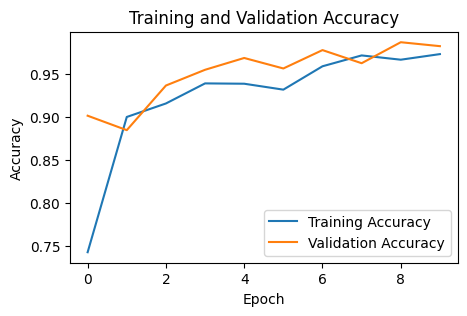

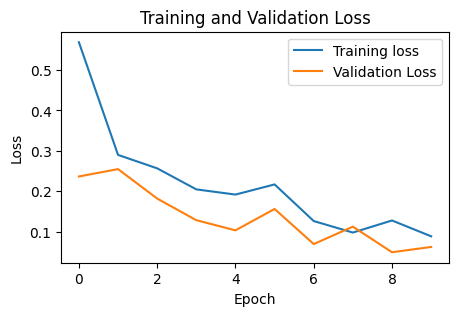

In [15]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#**Testing**

Saving f3d4b7d4-cc6d-478e-8255-e653ffe8a79c___JR_HL 8029.JPG to f3d4b7d4-cc6d-478e-8255-e653ffe8a79c___JR_HL 8029 (3).JPG
1/1 [==============================] - 0s 20ms/step


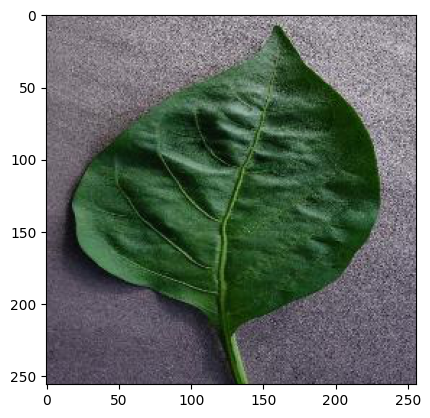

Pepper__bell___healthy: 97.54%


In [29]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

labels = list(train_generator.class_indices.keys())

upload = files.upload()

for fn in upload.keys():
    path = fn
    img = image.load_img(fn, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x / 255.0  
    x = np.expand_dims(x, axis=0)

    # Make predictions
    predictions = model.predict(x)
    
    plt.imshow(img)
    plt.show()
    
    for pred in predictions:
        # Find Class with Highest percentage
        max_index = np.argmax(pred)
        max_label = labels[max_index]
        max_percentage = pred[max_index] * 100

        print("{}: {:.2f}%".format(max_label, max_percentage))


Saving e8e03ae2-a11f-4af1-879b-66d71af9ba13___NREC_B.Spot 1857.JPG to e8e03ae2-a11f-4af1-879b-66d71af9ba13___NREC_B.Spot 1857 (8).JPG
1/1 [==============================] - 0s 20ms/step


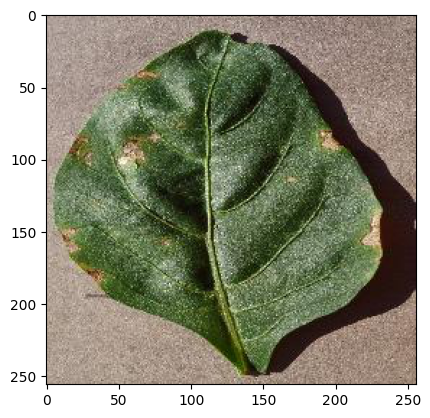

Pepper__bell___Bacterial_spot: 99.97%


In [30]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

labels = list(train_generator.class_indices.keys())

upload = files.upload()

for fn in upload.keys():
    path = fn
    img = image.load_img(fn, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x / 255.0  
    x = np.expand_dims(x, axis=0)

    # Make predictions
    predictions = model.predict(x)
    
    plt.imshow(img)
    plt.show()
    
    for pred in predictions:
        # Find Class with Highest percentage
        max_index = np.argmax(pred)
        max_label = labels[max_index]
        max_percentage = pred[max_index] * 100

        print("{}: {:.2f}%".format(max_label, max_percentage))


Saving Castle Block.png to Castle Block.png
1/1 [==============================] - 0s 19ms/step


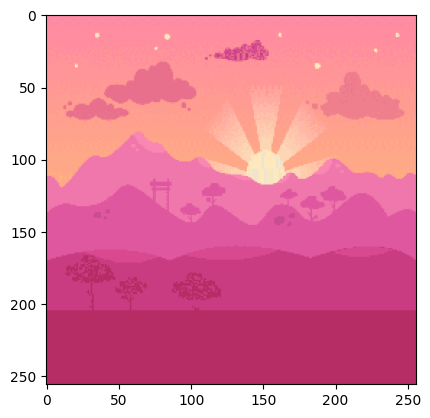

Not__Pepper__bell: 100.00%


In [32]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

labels = list(train_generator.class_indices.keys())

upload = files.upload()

for fn in upload.keys():
    path = fn
    img = image.load_img(fn, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x / 255.0  
    x = np.expand_dims(x, axis=0)

    # Make predictions
    predictions = model.predict(x)
    
    plt.imshow(img)
    plt.show()
    
    for pred in predictions:
        # Find Class with Highest percentage
        max_index = np.argmax(pred)
        max_label = labels[max_index]
        max_percentage = pred[max_index] * 100

        print("{}: {:.2f}%".format(max_label, max_percentage))


#**Saving Models**

In [33]:
# Save Final Model
model.save("pepperbell_model.h5")
tf.keras.models.save_model(model, 'pepperbell_model.hdf5')

In [38]:
from google.colab import files

# Download .h5
files.download('pepperbell_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
# Convert TF Lite
import tensorflow as tf

# Load Saved Model
last_model = tf.keras.models.load_model(filepath="pepperbell_model.h5")

# Convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(last_model)
model_tflite = converter.convert()

# Save TF Lite model
with tf.io.gfile.GFile('pepperbell_model.tflite', 'wb') as f:
  f.write(model_tflite)

In [43]:
from google.colab import files

# Download .tflite
files.download('pepperbell_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
# Save in JSON Format
model_json = model.to_json()
with open("pepperbell_model.json", "w") as json_file:
    json_file.write(model_json)

In [49]:
# Download JSON
files.download('pepperbell_model.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>